Instalar os Pacotes Pyrhon

In [ ]:
# Instale pacotes python 
!pip install numpy scikit-learn matplotlib
!pip install pandas
!python -m pip install --upgrade pip


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Importar Bibliotecas e Preparar os Dados
Nesta primeira parte, importamos tudo o que precisamos e definimos uma função para carregar o dataset MNIST. A função preparar_dados baixa os dados, normaliza os valores dos pixels para o intervalo entre 0 e 1, e divide o conjunto em treino e teste.

In [1]:
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import random
import time
import warnings

# Ignorar avisos de convergência do MLPClassifier para manter a saída limpa
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def preparar_dados():
    """Carrega o dataset MNIST e o prepara para o treinamento."""
    print("Carregando o dataset MNIST... (pode levar um momento)")
    try:
        mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
    except Exception as e:
        print(f"Falha ao carregar o dataset. Verifique sua conexão com a internet. Erro: {e}")
        return None, None, None, None

    X = mnist.data.astype('float32')
    y = mnist.target.astype('int64')

    # Normalizar os pixels para o intervalo [0, 1]
    X /= 255.0

    # Dividir em conjuntos de treino e teste (padrão MNIST é 60k treino, 10k teste)
    x_train, x_test = X[:60000], X[60000:]
    y_train, y_test = y[:60000], y[60000:]

    print("Dados carregados e preparados.")
    return x_train, y_train, x_test, y_test



2: Definir a Função de Fitness
A função de fitness é o coração do Algoritmo Genético. Ela recebe um "indivíduo" (um conjunto de hiperparâmetros) e mede o quão "bom" ele é. Para isso, ela cria um classificador MLPClassifier com esses hiperparâmetros, treina-o rapidamente e retorna sua acurácia no conjunto de teste. Esta acurácia é o valor de fitness.

In [3]:
def calcular_fitness(individuo, x_train, y_train, x_test, y_test):
    """Função de fitness: cria, treina e avalia um MLPClassifier."""
    print(f"\nAvaliando indivíduo: {individuo}")
    start_time = time.time()

    hidden_layer_sizes = tuple(individuo['neuronios_por_camada'])

    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        learning_rate_init=individuo['taxa_aprendizado'],
        activation='relu',
        solver='adam',
        batch_size=individuo['batch_size'],
        max_iter=30,  # Aumentamos as iterações para uma avaliação melhor
        random_state=1
    )

    # Treina o modelo com uma amostra dos dados para acelerar a avaliação
    indices = np.random.choice(len(x_train), 15000, replace=False)
    mlp.fit(x_train[indices], y_train[indices])

    # Avalia a acurácia (fitness)
    y_pred = mlp.predict(x_test)
    acuracia = accuracy_score(y_test, y_pred)

    end_time = time.time()
    print(f"Fitness (Acurácia): {acuracia:.4f} | Tempo: {end_time - start_time:.2f}s")

    return acuracia

3: Implementar a Lógica do Algoritmo Genético
Aqui estão as funções que definem o comportamento do GA. inicializar_populacao cria um conjunto de soluções aleatórias. selecao, cruzamento e mutacao são os operadores evolutivos que criam novas gerações de soluções a partir das existentes.

In [4]:
def inicializar_populacao(tamanho_populacao):
    """Cria a população inicial com indivíduos aleatórios."""
    populacao = []
    for _ in range(tamanho_populacao):
        num_camadas = random.randint(1, 3)
        neuronios = [random.choice([64, 128, 256]) for _ in range(num_camadas)]

        individuo = {
            'taxa_aprendizado': random.choice([0.005, 0.001, 0.0005]),
            'neuronios_por_camada': neuronios,
            'batch_size': random.choice([128, 256])
        }
        populacao.append(individuo)
    return populacao

def selecao(populacao, fitnesses):
    """Seleciona os melhores indivíduos para a próxima geração (torneio)."""
    proxima_geracao = []
    for _ in range(len(populacao)):
        i, j = random.sample(range(len(populacao)), 2)
        if fitnesses[i] > fitnesses[j]:
            proxima_geracao.append(populacao[i])
        else:
            proxima_geracao.append(populacao[j])
    return proxima_geracao

def cruzamento(pai1, pai2, taxa_cruzamento):
    """Realiza o cruzamento entre dois pais para gerar um filho."""
    if random.random() < taxa_cruzamento:
        filho = {
            'taxa_aprendizado': random.choice([pai1['taxa_aprendizado'], pai2['taxa_aprendizado']]),
            'batch_size': random.choice([pai1['batch_size'], pai2['batch_size']])
        }
        pai_estrutura = random.choice([pai1, pai2])
        filho['neuronios_por_camada'] = pai_estrutura['neuronios_por_camada'][:]
        return filho
    return random.choice([pai1, pai2]).copy()

def mutacao(individuo, taxa_mutacao):
    """Aplica mutações aleatórias em um indivíduo."""
    if random.random() < taxa_mutacao:
        param_mutado = random.choice(list(individuo.keys()))
        if param_mutado == 'taxa_aprendizado':
            individuo['taxa_aprendizado'] = random.choice([0.005, 0.001, 0.0005])
        elif param_mutado == 'batch_size':
            individuo['batch_size'] = random.choice([128, 256, 512])
        elif param_mutado == 'neuronios_por_camada':
            idx_camada = random.randint(0, len(individuo['neuronios_por_camada']) - 1)
            individuo['neuronios_por_camada'][idx_camada] = random.choice([64, 128, 256, 512])
    return individuo

4: Executar o Algoritmo Genético
Esta é a função principal que orquestra todo o processo. Ela inicializa a população e depois entra em um loop por várias gerações. Em cada geração, ela avalia a população, seleciona os melhores, cria novos filhos através de cruzamento e mutação, e armazena o melhor resultado. Ao final, plota o gráfico de convergência.

In [9]:
def rodar_ga(x_train, y_train, x_test, y_test, num_geracoes=10, tam_populacao=15, taxa_cruzamento=0.8, taxa_mutacao=0.2):
    """Função principal que executa o loop do GA."""
    print("\nIniciando o Algoritmo Genético com scikit-learn (parâmetros melhorados)...")
    populacao = inicializar_populacao(tam_populacao)
    melhor_individuo_geral = None
    melhor_fitness_geral = 0
    historico_fitness = []

    for geracao in range(num_geracoes):
        print(f"\n======= GERAÇÃO {geracao + 1}/{num_geracoes} =======")
        fitnesses = [calcular_fitness(ind, x_train, y_train, x_test, y_test) for ind in populacao]

        melhor_fitness_geracao = max(fitnesses)
        historico_fitness.append(melhor_fitness_geracao)

        if melhor_fitness_geracao > melhor_fitness_geral:
            melhor_fitness_geral = melhor_fitness_geracao
            melhor_individuo_geral = populacao[np.argmax(fitnesses)]

        print(f"\nMelhor fitness da Geração {geracao + 1}: {melhor_fitness_geracao:.4f}")

        selecionados = selecao(populacao, fitnesses)
        proxima_geracao = []
        for _ in range(tam_populacao):
            pai1 = random.choice(selecionados)
            pai2 = random.choice(selecionados)
            filho = cruzamento(pai1, pai2, taxa_cruzamento)
            proxima_geracao.append(mutacao(filho, taxa_mutacao))
        populacao = proxima_geracao

    print(f"\n======= OTIMIZAÇÃO CONCLUÍDA =======")
    print(f"Melhor indivíduo encontrado: {melhor_individuo_geral}")
    print(f"Melhor fitness (acurácia): {melhor_fitness_geral:.4f}")

    # Plotar o gráfico de convergência
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_geracoes + 1), historico_fitness, marker='o', linestyle='-')
    plt.title('Convergência do Algoritmo Genético')
    plt.xlabel('Geração')
    plt.ylabel('Melhor Fitness (Acurácia)')
    plt.grid(True)
    plt.show()

    return melhor_individuo_geral

5: Treinar e Avaliar o Modelo Final
Após o GA encontrar o que parece ser o melhor conjunto de hiperparâmetros, usamos esses parâmetros para treinar um modelo final. Desta vez, o modelo é treinado com o conjunto de dados completo e por mais iterações para garantir o melhor desempenho possível. Finalmente, geramos o relatório de classificação com todas as métricas exigidas.

Carregando o dataset MNIST... (pode levar um momento)
Dados carregados e preparados.

Iniciando o Algoritmo Genético com scikit-learn (parâmetros melhorados)...

======= GERAÇÃO 1/10 =======

Avaliando indivíduo: {'taxa_aprendizado': 0.0005, 'neuronios_por_camada': [256, 64], 'batch_size': 128}
Fitness (Acurácia): 0.9676 | Tempo: 44.10s

Avaliando indivíduo: {'taxa_aprendizado': 0.0005, 'neuronios_por_camada': [128, 128, 256], 'batch_size': 256}
Fitness (Acurácia): 0.9644 | Tempo: 13.09s

Avaliando indivíduo: {'taxa_aprendizado': 0.005, 'neuronios_por_camada': [256, 256], 'batch_size': 128}
Fitness (Acurácia): 0.9627 | Tempo: 90.40s

Avaliando indivíduo: {'taxa_aprendizado': 0.005, 'neuronios_por_camada': [256], 'batch_size': 128}
Fitness (Acurácia): 0.9741 | Tempo: 53.66s

Avaliando indivíduo: {'taxa_aprendizado': 0.0005, 'neuronios_por_camada': [256, 64, 128], 'batch_size': 256}
Fitness (Acurácia): 0.9651 | Tempo: 15.77s

Avaliando indivíduo: {'taxa_aprendizado': 0.005, 'neuronios_po

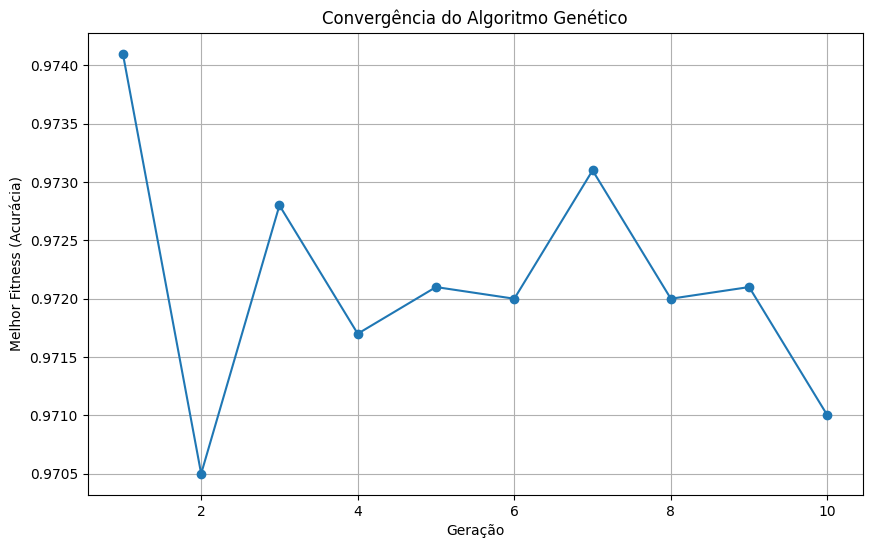


======= TREINAMENTO E AVALIAÇÃO DO MODELO FINAL =======
Treinando o modelo final com os dados completos...
Iteration 1, loss = 0.20747389
Iteration 2, loss = 0.08635773
Iteration 3, loss = 0.06387254
Iteration 4, loss = 0.04801823
Iteration 5, loss = 0.04267881
Iteration 6, loss = 0.03559320
Iteration 7, loss = 0.02949840
Iteration 8, loss = 0.03140178
Iteration 9, loss = 0.03130553
Iteration 10, loss = 0.02949141
Iteration 11, loss = 0.02643825
Iteration 12, loss = 0.02555556
Iteration 13, loss = 0.02982071
Iteration 14, loss = 0.02434122
Iteration 15, loss = 0.01777372
Iteration 16, loss = 0.02893786
Iteration 17, loss = 0.02314801
Iteration 18, loss = 0.02442040
Iteration 19, loss = 0.02194424
Iteration 20, loss = 0.02085810
Iteration 21, loss = 0.02924157
Iteration 22, loss = 0.02417223
Iteration 23, loss = 0.01894171
Iteration 24, loss = 0.01789777
Iteration 25, loss = 0.02553941
Iteration 26, loss = 0.02835199
Training loss did not improve more than tol=0.000100 for 10 consecuti

In [10]:
def avaliar_modelo_final(individuo, x_train, y_train, x_test, y_test):
    """Treina e avalia o modelo final."""
    if individuo is None:
        print("\nNenhum indivíduo para treinar. Encerrando.")
        return

    print("\n======= TREINAMENTO E AVALIAÇÃO DO MODELO FINAL =======")
    start_time = time.time()

    modelo_final = MLPClassifier(
        hidden_layer_sizes=tuple(individuo['neuronios_por_camada']),
        learning_rate_init=individuo['taxa_aprendizado'],
        batch_size=individuo['batch_size'],
        activation='relu',
        solver='adam',
        max_iter=100, # Mais iterações para o treino final
        verbose=True,
        random_state=1
    )

    print("Treinando o modelo final com os dados completos...")
    modelo_final.fit(x_train, y_train)

    print("\nRealizando predições e gerando relatório...")
    y_pred = modelo_final.predict(x_test)

    report = classification_report(y_test, y_pred)
    acuracia_final = accuracy_score(y_test, y_pred)

    print("\n--- Relatório de Classificação Final ---")
    print(report)
    print("\n--- Comparação com o Artigo ---")
    print(f"Acurácia Final Obtida: {acuracia_final:.4f}")
    print(f"Acurácia do Artigo (com GA): 98.85%")

    end_time = time.time()
    print(f"\nTempo total de treinamento e avaliação final: {end_time - start_time:.2f}s")

# Bloco de execução principal
# Bloco de execução principal
if __name__ == '__main__':
    x_train_data, y_train_data, x_test_data, y_test_data = preparar_dados()
    if x_train_data is not None:
        melhores_hiperparametros = rodar_ga(x_train_data, y_train_data, x_test_data, y_test_data)
        avaliar_modelo_final(melhores_hiperparametros, x_train_data, y_train_data, x_test_data, y_test_data)